In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data_general_model = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz', allow_pickle=True)
data_communication_simulation = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz', allow_pickle=True)

Mounted at /content/drive


In [3]:
# Access the saved data from the .npz file
all_EventCount = data_general_model['all_EventCount']
all_DeviceActiveCount = data_general_model['all_DeviceActiveCount']
all_DeviceProbability = data_general_model['all_DeviceProbability']
all_DeviceAlarmStatus = data_general_model['all_DeviceAlarmStatus']
all_DeviceStatus = data_general_model['all_DeviceStatus']
all_DeviceLocations = data_general_model['all_DeviceLocations']
all_DeviceLocationsPolar = data_general_model['all_DeviceLocationsPolar']
all_EventLocations = data_general_model['all_EventLocations']
all_EventLocationsPolar = data_general_model['all_EventLocationsPolar']
device_count = data_general_model['device_count']
event_count = data_general_model['event_count']
bs_location = data_general_model['bs_location']
bs_radius = data_general_model['bs_radius']
k = data_general_model['k']
sparsity = data_general_model['sparsity']
num_samples = data_general_model['num_samples']

all_theta = data_communication_simulation['all_theta']
all_gamma = data_communication_simulation['all_gamma']
all_z = data_communication_simulation['all_z']
all_noise = data_communication_simulation['all_noise']
all_received_signal = data_communication_simulation['all_received_signal']
snr_db_array = data_communication_simulation['snr_db_array']
pilot_length_array = data_communication_simulation['pilot_length_array']
M = data_communication_simulation['M']

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

In [4]:
num_samples=2

In [5]:
print(M)

4


SBL

In [6]:
import numpy as np

def sbl_algorithm(A, y, N, sig2e, Tau_p, max_iter_sbl=500, stopping_criterion=1e-4):
    """Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess
    xhat_sbl = np.zeros((N, M), dtype=np.complex128)  # Final estimate

    # Iteration over the maximum number of iterations
    for t in range(max_iter_sbl):
        # Compute mean and covariance of x
        Gamma_inv = np.linalg.solve(Gamma, np.eye(Gamma.shape[0]))
        Sigma_x_inv = (1/sig2e) * A.conj().T @ A + Gamma_inv
        Sigma_x = np.linalg.solve(Sigma_x_inv, np.eye(Sigma_x_inv.shape[0], dtype=np.complex128))
        mu_x = (1/sig2e) * Sigma_x @ A.conj().T @ y

        # Update gamma values (vectorized for efficiency)
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))  # Ensure real values

        # Check for convergence
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma
        Gamma = np.diagflat(gamma_new)

    return mu_x, np.diag(Gamma)  # Final estimates


In [7]:
# Placeholder arrays for SBL results
z_sbl = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # SBL results
gamma_sbl = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # SBL gamma values
hit_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Hit rate for SBL
miss_detection_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Miss detection rate for SBL
false_alarm_rate_sbl = np.zeros((num_samples, len(pilot_length_array)))  # False alarm rate for SBL
norm_mse_sbl = np.zeros((num_samples, len(pilot_length_array)))  # Norm MSE for SBL

In [8]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length)

        # Store the results
        z_sbl[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_sbl[sample_index, pilot_length_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for SBL
        hit_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the miss detection rate for SBL
        miss_detection_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 0) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the false alarm rate for SBL
        false_alarm_rate_sbl[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for SBL
        norm_mse_sbl[sample_index, pilot_length_index] = (
            np.linalg.norm(z - z_result)**2 / max(1e-10, np.linalg.norm(z)**2)
        )  # Avoid division by zero


Processing Samples: 100%|██████████| 2/2 [07:15<00:00, 217.64s/it]


In [9]:
# Compute the average across all samples for each SNR level
avg_hit_rate_sbl = np.mean(hit_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_miss_detection_rate_sbl = np.mean(miss_detection_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_sbl = np.mean(false_alarm_rate_sbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_sbl = np.mean(norm_mse_sbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_sbl)
print("Average Miss Detection Rate across samples per SNR level:", avg_miss_detection_rate_sbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_sbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_sbl)

Average Hit Rate across samples per SNR level: [ 57.5  62.5  85.   95.   97.5 100. ]
Average Miss Detection Rate across samples per SNR level: [42.5 37.5 15.   5.   2.5  0. ]
Average False Alarm Rate across samples per SNR level: [3.55263158 4.73684211 2.10526316 1.84210526 1.44736842 0.39473684]
Average Normalized MSE across samples per SNR level: [0.74629593 0.67808    0.30455474 0.18741304 0.14798844 0.08332637]


In [10]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e4_results_sbl_pilot_length.npz',
                    z_sbl=z_sbl,
                    gamma_sbl=gamma_sbl,
                    hit_rate_sbl=hit_rate_sbl,
                    miss_detection_rate_sbl=miss_detection_rate_sbl,
                    false_alarm_rate_sbl=false_alarm_rate_sbl,
                    norm_mse_sbl=norm_mse_sbl,
                    avg_hit_rate_sbl=avg_hit_rate_sbl,
                    avg_miss_detection_rate_sbl=avg_miss_detection_rate_sbl,
                    avg_false_alarm_rate_sbl=avg_false_alarm_rate_sbl,
                    avg_norm_mse_sbl=avg_norm_mse_sbl,
                    pilot_length_array=pilot_length_array,
                    snr_db=snr_db)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


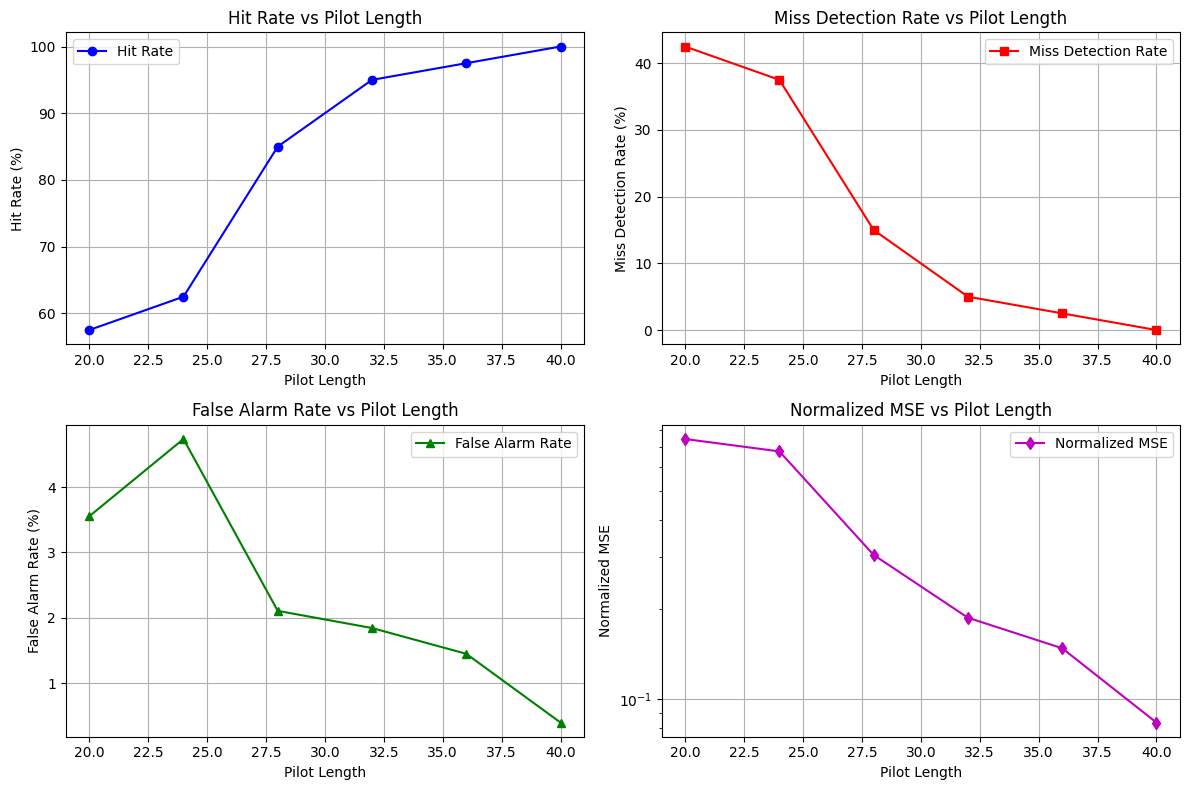

In [11]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(pilot_length_values, avg_hit_rate_sbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(pilot_length_values, avg_miss_detection_rate_sbl, marker='s', linestyle='-', color='r', label='Miss Detection Rate')
plt.xlabel("Pilot Length")
plt.ylabel("Miss Detection Rate (%)")
plt.title("Miss Detection Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(pilot_length_values, avg_false_alarm_rate_sbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(pilot_length_values, avg_norm_mse_sbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
